In [16]:
from Data.load import load
from Architectures.AE import AE
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
from tensorflow.keras import utils

The idea of this notebook is to show the information density of each band of frequencies in the fourier transformed frequency representation of an MRI scan to gain insight into which scale of reconstruction detail is necessary to achieve a good latent representation of the encoded scans. To do this, we can see how accuracy of a classifier behaves as we mask out certain frequencies, similar to how PFI removes information and looks at the results.

In [25]:
groups = {
    group:load(f"Pre-processed/{group}", take=50, train_test_split=1)
    for group in ["CN", "AD"] # "MCI",
}

images = []
labels = []
for i, group in enumerate(groups.values()):
    images.extend(group)
    labels.extend([i]*len(group))

images = np.stack(images)
labels = utils.to_categorical(labels)
labels.shape

Loading images: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]


(76, 2)

In [53]:
def mask_freq_band(im, band_low, band_high, pass_inner=True):
    # Compute the 3D FFT of the image
    fft_im = np.fft.fftn(im)
    fft_shift = np.fft.fftshift(fft_im)
    
    # Get frequency grid
    shape = im.shape
    x = np.fft.fftfreq(shape[0])
    y = np.fft.fftfreq(shape[1])
    z = np.fft.fftfreq(shape[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    freq_magnitude = np.sqrt(X**2 + Y**2 + Z**2)
    
    # Create mask
    mask = (freq_magnitude < band_low) | (freq_magnitude > band_high)
    if pass_inner: mask=1-mask
    
    # Apply mask
    fft_shift *= mask
    
    # Inverse FFT to reconstruct image
    fft_im = np.fft.ifftshift(fft_shift)
    filtered_im = np.fft.ifftn(fft_im).real
    
    return filtered_im

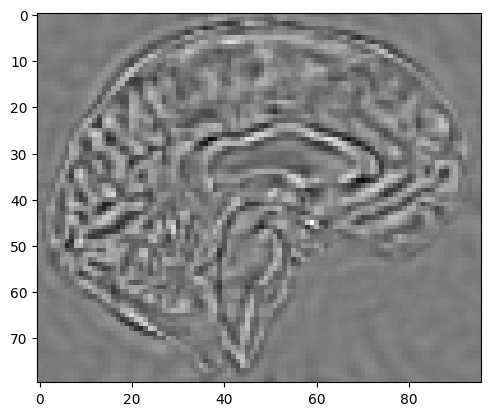

In [88]:
im1 = mask_freq_band(images[2],0.5,0.7,True)
plt.imshow(np.rot90(im1[40]),cmap="gray")

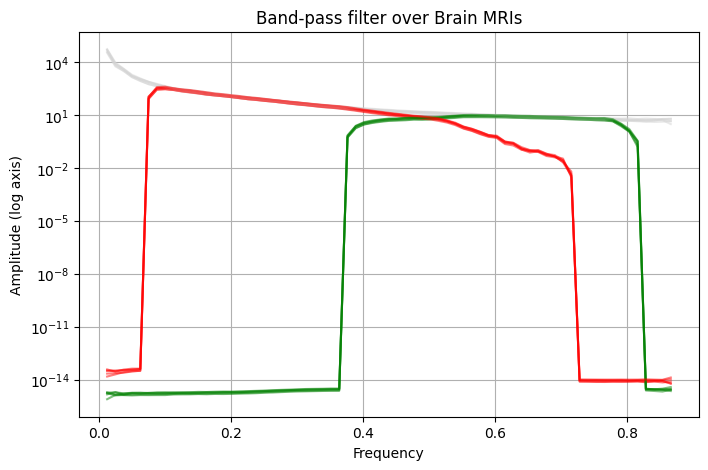

In [74]:
def draw_fft(mri_scan,color=None,alpha=1):
    # Compute the 3D FFT
    fft_result = np.fft.fftn(mri_scan)

    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(fft_result)

    # Compute frequency bins
    freqs_x = np.fft.fftfreq(mri_scan.shape[0])
    freqs_y = np.fft.fftfreq(mri_scan.shape[1])
    freqs_z = np.fft.fftfreq(mri_scan.shape[2])

    # Compute overall frequency magnitude
    freq_magnitude = np.sqrt(freqs_x[:, None, None]**2 + freqs_y[None, :, None]**2 + freqs_z[None, None, :]**2)

    # Flatten arrays
    freq_magnitude_flat = freq_magnitude.flatten()
    amplitude_flat = amplitude_spectrum.flatten()

    # Bin the data
    bins = np.linspace(0, np.max(freq_magnitude_flat), num=70)
    bin_indices = np.digitize(freq_magnitude_flat, bins)
    binned_amplitude = [amplitude_flat[bin_indices == i].mean() if np.any(bin_indices == i) else 0 for i in range(len(bins))]
    binned_amplitude = np.clip(binned_amplitude, 0, 70_000)
    if color is None:
        plt.plot(bins[1:], binned_amplitude[1:],alpha=alpha)
    else:
        plt.plot(bins[1:], binned_amplitude[1:], color=color,alpha=alpha)

# Plot amplitude vs frequency
plt.figure(figsize=(8, 5))
plt.xlabel("Frequency")
plt.ylabel("Amplitude (log axis)")
plt.title("Band-pass filter over Brain MRIs")

for im in images[:5]:
    draw_fft(im,color="lightgray",alpha=0.5)
    draw_fft(mask_freq_band(im,0.1,0.5),color="green",alpha=0.5)
    draw_fft(mask_freq_band(im,0.5,0.8),color="red",alpha=0.5)
    
plt.yscale("log")
plt.grid(True)
plt.show()

In [75]:
# Shuffle the dataset
indices = np.arange(images.shape[0])
np.random.shuffle(indices)

images = images[indices]
labels = labels[indices]
indices

array([31, 56, 68, 48, 45, 25, 61, 11, 75, 33, 46, 59, 60, 17,  1, 52, 63,
       14, 51,  9, 28, 42, 57, 71, 73,  4, 67, 23, 10, 30, 19, 58, 39, 21,
       15, 26,  7, 20,  6, 41, 37, 18, 29, 64,  8, 24, 43, 74, 50, 34,  2,
       35, 54, 62, 44, 22, 70, 16, 72, 40, 55, 12, 69, 36, 66, 32, 65, 38,
       47,  0, 27, 13,  3, 53, 49,  5])

In [89]:
band_width = 0.2
band_starts = np.linspace(0, 0.9, num=20)
num_freqs = 100  # Assume 100 frequency bins for visualization

# Store classifier scores
scores = []

# Create an empty matrix to track which frequencies are masked in each experiment
M = np.zeros((len(band_starts), num_freqs))

for i, band_start in enumerate(band_starts):
    band_end = band_start + band_width

    # Mask out these frequencies
    images_ = np.stack([mask_freq_band(im, band_start, band_end) for im in images])
    print("Images masked")

    # Train the classifier
    model = models.Sequential([
        layers.Input(shape=(80,96,80,1)),
        layers.Conv3D(5, 4, strides=2),
        layers.Conv3D(25, 3, strides=2),
        layers.Conv3D(60, 3, strides=2),
        layers.Conv3D(110, 3, strides=2),
        layers.Flatten(),
        layers.Dense(labels.shape[1], activation='softmax')
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    hist = model.fit(images_, labels, epochs=70, validation_split=0.4, shuffle=False) # Use the pre-shuffled dataset
    acc = hist.history['val_accuracy'][-1]
    scores.append(acc)
    print(f"Accuracy for band ({band_start}, {band_end}): {acc}")

    # Construct the mask matrix M
    start_idx = int(band_start * num_freqs)
    end_idx = min(int(band_end * num_freqs), num_freqs)
    M[i, start_idx:end_idx] = 1  # Mark masked frequencies

Images masked
Epoch 1/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.4317 - loss: 0.6928 - val_accuracy: 0.7097 - val_loss: 0.6655
Epoch 2/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6336 - loss: 0.6770 - val_accuracy: 0.7097 - val_loss: 0.6363
Epoch 3/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6336 - loss: 0.6590 - val_accuracy: 0.7097 - val_loss: 0.6390
Epoch 4/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6336 - loss: 0.6590 - val_accuracy: 0.7097 - val_loss: 0.6346
Epoch 5/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6336 - loss: 0.6558 - val_accuracy: 0.7097 - val_loss: 0.6292
Epoch 6/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6336 - loss: 0.6515 - val_accuracy: 0.7097 - val_loss: 0.6274
Epoch 7/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6336 - loss: 0.6475 - val_accuracy: 0.7097 - val_loss: 0.6284
Epoch 8/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6336 - loss: 0.6433 - val_accuracy: 0.7097 - va

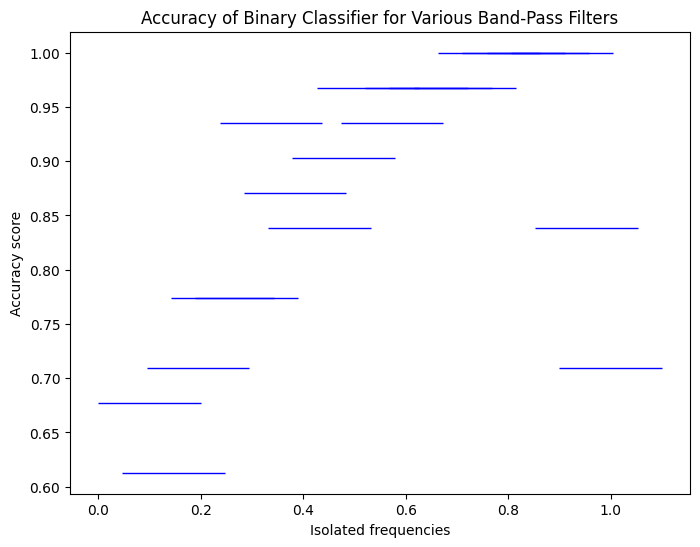

In [95]:
plt.figure(figsize=(8, 6))
for bs, score in zip(band_starts, scores):
    plt.hlines(score, xmin=bs, xmax=bs+band_width, colors='b', linewidth=1)

# Labels and title
plt.xlabel("Isolated frequencies")
plt.ylabel("Accuracy score")
plt.title("Accuracy of Binary Classifier for Various Band-Pass Filters")

plt.show()

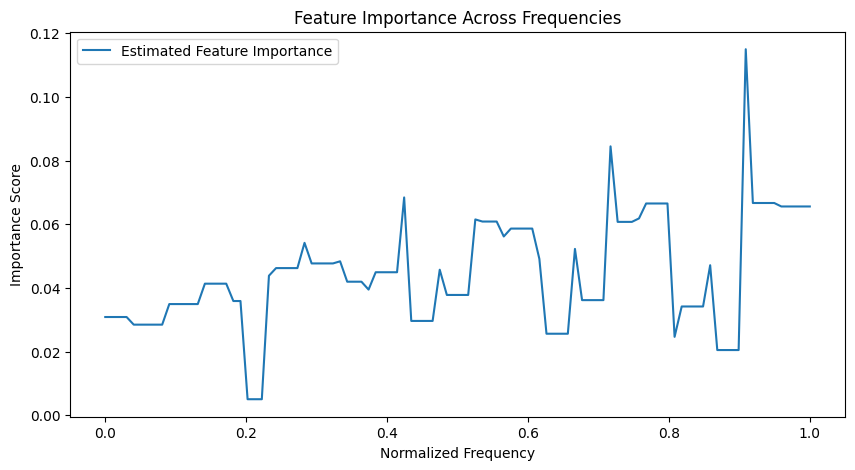

In [90]:
# Convert scores to a NumPy array
S = np.array(scores)

# Solve for individual frequency importance using least squares
F = np.linalg.pinv(M) @ S

# Plot the feature importance
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 1, num_freqs), F, label="Estimated Feature Importance")
plt.xlabel("Normalized Frequency")
plt.ylabel("Importance Score")
plt.title("Feature Importance Across Frequencies")
plt.legend()
plt.show()